# Build Models with Reason Codes and Filtered Columns

## Import MLFlow libraries

In [1]:
import os
import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from IPython.display import Markdown, display
import joblib

## Import Numpy, Matplotlib, Sklearn libraries

In [2]:
from numpy import mean
from numpy import std
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
import shap

# load the dataset


## Define scoring precision-recall area under curve, evaluate model

In [3]:
# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # calculate precision-recall curve
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    # calculate area under curve
    return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model,name):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    model.fit(X,y)        
    return scores, model

def printmd(string):
    display(Markdown(string))

## Create a list of models to build -- Add XGBoost, LightGBM

In [4]:
# define models to test
def get_models():
    models, names = list(), list()
    # CART
    steps = [('s',StandardScaler()),('m',DecisionTreeClassifier())]
    models.append(Pipeline(steps=steps))
    names.append('CART')
    # RF
    steps = [('s',StandardScaler()),('m',RandomForestClassifier(n_estimators=100))]
    models.append(Pipeline(steps=steps))
    names.append('RF')
    # ET
    steps = [('s',StandardScaler()),('m',ExtraTreesClassifier(n_estimators=100))]
    models.append(Pipeline(steps=steps))
    names.append('ET')
    #XGBoost
    steps = [('s',StandardScaler()),('m',XGBClassifier(n_estimators=100))]
    models.append(Pipeline(steps=steps))
    names.append('XGBoost')
    #LGBMClassifier
    steps = [('s',StandardScaler()),('m',LGBMClassifier(n_estimators=100))]
    models.append(Pipeline(steps=steps))
    names.append('LightGBM')
    return models, names

## Set MLFlow Experiment in which you want to track your runs

In [5]:
## Setup MLFLOW
tracking_uri = os.environ.get("TRACKING_URL")
client = MlflowClient(tracking_uri=tracking_uri)
mlflow.set_tracking_uri(tracking_uri)
experiments = client.list_experiments()
experiment_names = []
for exp in experiments:
    experiment_names.append(exp.name)
experiment_name = "demo_2"
if experiment_name not in experiment_names:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

## Training samples and targets

In [6]:
full_path = 'credit_card_train.csv'
df = pd.read_csv(full_path)

In [7]:
y = df["Target"]
df = df.drop(["Target"],axis=1)
X = df

## Undersampler to handle imbalanced data and build models

In [8]:
# define the location of the dataset
# load the dataset
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# X_resampled, y_resampled = SMOTE().fit_resample(X, y)
# summarize the loaded dataset
models, names = get_models()
results = list()
fit_models = list()
scores_list = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores,fit_model = evaluate_model(X_resampled, y_resampled, models[i],names[i])
    results.append(scores)
    fit_models.append(fit_model)
    scores_list.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

>CART 0.925 (0.025)
>RF 0.983 (0.012)
>ET 0.985 (0.013)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:54:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
>XGBoost 0.985 (0.014)
>LightGBM 0.981 (0.024)


## Explainability using Shapley Values

## CART Index 0

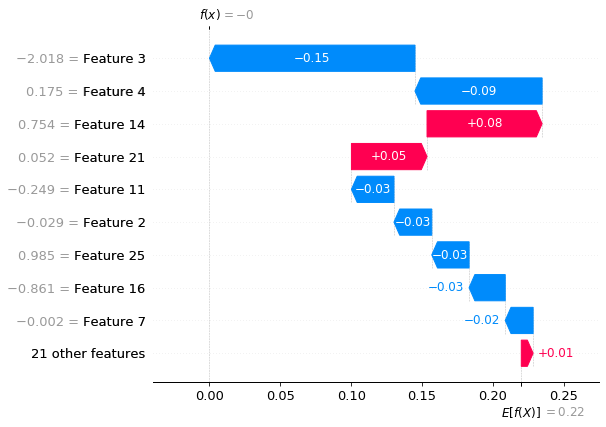

## RF Index 1

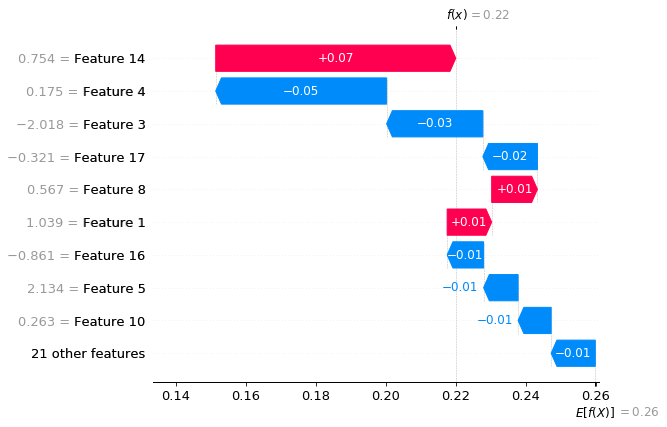

## ET Index 2

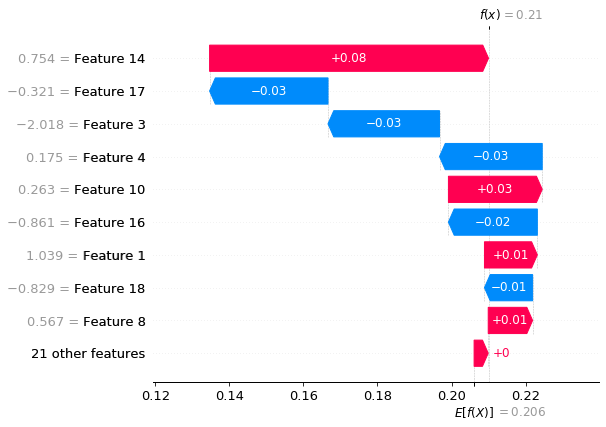

## XGBoost Index 3

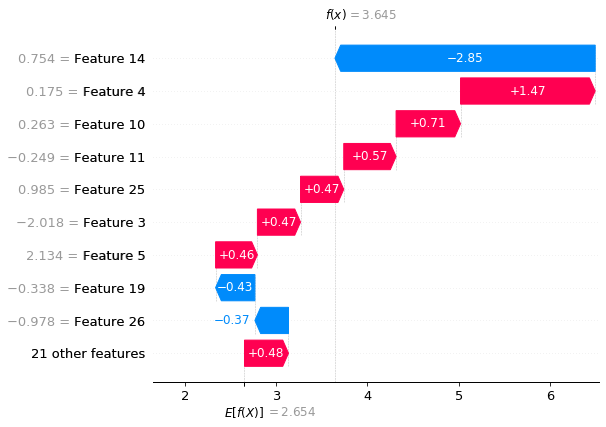

## LightGBM Index 4

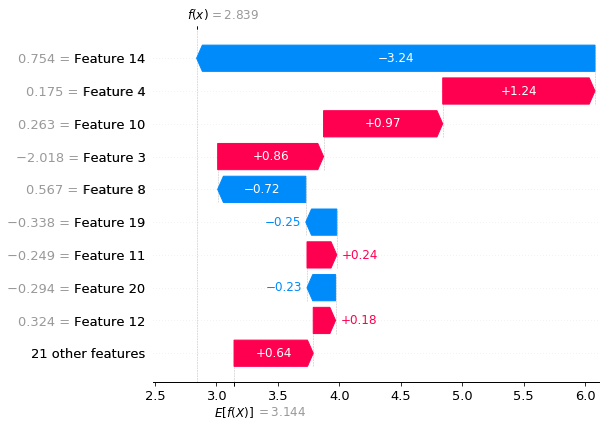

In [9]:
explainer_list = list()
index = 0
for fit_model,name in zip(fit_models,names):
    X_t = fit_model.named_steps['s'].fit_transform(X)
    explainer = shap.TreeExplainer(fit_model.named_steps['m'],X_t)
    explainer_list.append(explainer)
    shap_values = explainer(X_t[0:10])
    printmd('## '+ name + " Index " + str(index))
    if len(shap_values.shape) > 2:
        shap.plots.waterfall(shap_values[1,:,0])
    else:
        shap.plots.waterfall(shap_values[1,:])
    index = index+1

In [10]:
def add_libraries_to_conda_env(_conda_env,libraries=[],conda_dependencies=[]):
    dependencies = _conda_env["dependencies"]
    dependencies = dependencies + conda_dependencies
    pip_index = None
    for _index,_element in enumerate(dependencies):
        if type(_element) == dict:
            if "pip" in _element.keys():
                pip_index = _index
                break
    dependencies[pip_index]["pip"] =  dependencies[pip_index]["pip"] + libraries
    _conda_env["dependencies"] = dependencies
    return _conda_env

## Custom Model with reason codes

In [11]:
class ModelWrapper(mlflow.pyfunc.PythonModel):
    
    def load_context(self,context):
        import joblib
        import shap
        pipeline_model  = context.artifacts["pipeline_model"]
        self.pipeline  = joblib.load(filename=pipeline_model)
        self.explainer = shap.TreeExplainer(self.pipeline.named_steps['m'])

    def predict(self, context, model_input):
        predictions = self.pipeline.predict(model_input)
        X_t = self.pipeline.named_steps['s'].transform(model_input)
        shap_values = self.explainer(X_t)
        return {"predictions": predictions, "shap_values" : shap_values.values, "shap_base_values" : shap_values.base_values, "shap_data" : X_t}
        

In [12]:
index = 4
pipeline_filename = 'pipeline.bz2'
joblib.dump(fit_models[index],filename=pipeline_filename,compress=('bz2', 9))

['pipeline.bz2']

## Log a model with custom artifacts, pip libraries, conda libraries

In [13]:
with mlflow.start_run():
    mlflow.log_param("Model","LightGBM")
    mlflow.log_metric("Mean Score", mean(scores_list[4]))
    mlflow.log_metric("Std Score" , std(scores_list[4]))
    model_artifacts = {"pipeline_model": "pipeline.bz2"}
    pyfunc_model = ModelWrapper()
    conda_env = mlflow.sklearn.get_default_conda_env()
    conda_env = add_libraries_to_conda_env(conda_env,libraries=["lightgbm==3.1.1"],conda_dependencies=["shap==0.39.0"])
    mlflow.pyfunc.log_model("model",python_model=pyfunc_model,artifacts=model_artifacts,conda_env=conda_env)

## Custom Model that can filter columns

In [14]:
class ModelWrapperWithFilter(mlflow.pyfunc.PythonModel):
    
    def load_context(self,context):
        import joblib
        import shap
        pipeline_model  = context.artifacts["pipeline_model"]
        self.pipeline  = joblib.load(filename=pipeline_model)
        self.explainer = shap.TreeExplainer(self.pipeline.named_steps['m'])

    def filter_columns(self,model_input):
        column_names = ["V"+str(i) for i in range(30)]
        return model_input[column_names]
    
    def predict(self, context, model_input):
        model_input = self.filter_columns(model_input)
        predictions = self.pipeline.predict(model_input)
        X_t = self.pipeline.named_steps['s'].transform(model_input)
        shap_values = self.explainer(X_t)
        return {"predictions": predictions, "shap_values" : shap_values.values, "shap_base_values" : shap_values.base_values, "shap_data" : X_t}
        

## Log this new model with custom artifacts, pip libraries, conda libraries

In [17]:
with mlflow.start_run():
    mlflow.log_param("Model","LightGBM")
    mlflow.log_metric("Mean Score", mean(scores_list[4]))
    mlflow.log_metric("Std Score" , std(scores_list[4]))
    mlflow.log_param("ColumnFilter","Yes")
    model_artifacts = {"pipeline_model": "pipeline.bz2"}
    pyfunc_model = ModelWrapperWithFilter()
    conda_env = mlflow.sklearn.get_default_conda_env()
    conda_env = add_libraries_to_conda_env(conda_env,libraries=["lightgbm==3.1.1"],conda_dependencies=["shap==0.39.0"])
    mlflow.pyfunc.log_model("model",python_model=pyfunc_model,artifacts=model_artifacts,conda_env=conda_env)